# DMT LAOS (Large Amplitude Oscillatory Shear)

## Learning Objectives

- Understand LAOS as a probe of nonlinear viscoelasticity
- Visualize Lissajous-Bowditch curves (elastic and viscous)
- Analyze Fourier harmonics and nonlinearity ratios
- Observe intra-cycle structure evolution
- Explore the nonlinear regime of DMT thixotropic models

## Prerequisites

- Notebook 01 (DMT fundamentals)
- Notebook 05 (DMT SAOS and oscillatory response)

## Runtime

- Data generation + visualization: ~2-5 minutes
- Optional Bayesian inference: ~10-20 minutes (single chain, reduced samples)

## Setup

In [1]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("Running locally")

Running locally


In [2]:
# Install RheoJAX if in Colab
if IN_COLAB:
    !pip install -q rheojax arviz
    import os
    os.environ["JAX_ENABLE_X64"] = "1"
    print("Installed RheoJAX and enabled float64")

In [3]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# RheoJAX imports
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import DMTLocal
from rheojax.logging import configure_logging, get_logger

# Import JAX through safe wrapper
jax, jnp = safe_import_jax()

# Verify float64
verify_float64()

# Configure logging
configure_logging(level="INFO")
logger = get_logger(__name__)

# Matplotlib inline
%matplotlib inline

print("Imports successful")
print(f"JAX devices: {jax.devices()}")

Imports successful
JAX devices: [CpuDevice(id=0)]


In [4]:
# Create output directory
output_dir = Path("outputs/dmt/laos")
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {output_dir.absolute()}")

Output directory: /Users/b80985/Projects/rheojax/examples/dmt/outputs/dmt/laos


## Theory: LAOS Fundamentals

### Oscillatory Strain Input

LAOS applies a large-amplitude sinusoidal strain:

$$\gamma(t) = \gamma_0 \sin(\omega t)$$
$$\dot{\gamma}(t) = \gamma_0 \omega \cos(\omega t)$$

where $\gamma_0$ is the strain amplitude (typically 0.1-10) and $\omega$ is the angular frequency.

### Nonlinear Response

At large $\gamma_0$, the material response becomes nonlinear:

- **Linear regime** ($\gamma_0 \ll 1$): $\sigma(t) = \gamma_0 [G' \sin(\omega t) + G'' \cos(\omega t)]$
- **Nonlinear regime** ($\gamma_0 \sim 1$): Distorted waveforms, higher harmonics appear

### Fourier Decomposition

The stress response is decomposed into odd harmonics:

$$\sigma(t) = \sum_{n=1,3,5,...} \left[ \sigma'_n \sin(n\omega t) + \sigma''_n \cos(n\omega t) \right]$$

The nonlinearity ratio $I_3/I_1$ quantifies nonlinear behavior:

$$I_n = \sqrt{(\sigma'_n)^2 + (\sigma''_n)^2}$$

### Lissajous-Bowditch Curves

- **Elastic Lissajous**: $\sigma$ vs $\gamma$ (ellipse → distorted loop)
- **Viscous Lissajous**: $\sigma$ vs $\dot{\gamma}$ (ellipse → distorted loop)

### Intra-Cycle Structure

For DMT models, the structure parameter $\lambda(t)$ evolves within each cycle:

$$\frac{d\lambda}{dt} = \frac{1 - \lambda}{t_{\text{eq}}} - \frac{a \lambda |\dot{\gamma}|^c}{t_{\text{eq}}}$$

At large $\gamma_0$, $\lambda$ oscillates between high (structured) and low (broken) states.

## Generate Synthetic Data

We simulate LAOS at four strain amplitudes spanning linear to strongly nonlinear regimes.

In [5]:
# Calibration parameters (similar to previous notebooks)
calib_params = {
    "eta_0": 1.5e4,      # Zero-shear viscosity (Pa·s)
    "eta_inf": 0.3,      # Infinite-shear viscosity (Pa·s)
    "a": 0.8,            # Structure breakdown rate
    "c": 0.7,            # Shear-rate exponent
    "G0": 500.0,         # Elastic modulus (Pa)
    "m_G": 1.0,          # Structure-modulus coupling
    "t_eq": 50.0,        # Equilibrium timescale (s)
}

# Create model with exponential closure and elasticity
model = DMTLocal(closure="exponential", include_elasticity=True)

# Set parameters
for param_name, value in calib_params.items():
    param = model.parameters.get(param_name)
    if param is not None:
        param.value = value
        param.fixed = True

print("Model parameters:")
for name, param in model.parameters.items():
    print(f"  {name}: {param.value:.4e}")

07:21:28 | INFO     | rheojax.models.dmt.local | DMTLocal initialized | closure=exponential | include_elasticity=True


Model parameters:
  eta_0: 1.5000e+04
  eta_inf: 3.0000e-01
  G0: 5.0000e+02
  m_G: 1.0000e+00
  t_eq: 5.0000e+01
  a: 8.0000e-01
  c: 7.0000e-01


In [6]:
# Simulate at four strain amplitudes
amplitudes = [0.01, 0.1, 0.5, 2.0]  # Linear → strongly nonlinear
omega = 1.0  # rad/s
n_cycles = 10
lam_init = 1.0  # Fully structured initial state

results = {}
results_noisy = {}

print(f"Simulating LAOS at {len(amplitudes)} strain amplitudes...")
for gamma_0 in amplitudes:
    print(f"  γ₀ = {gamma_0:.2f}...", end="")
    result = model.simulate_laos(
        gamma_0=gamma_0,
        omega=omega,
        n_cycles=n_cycles,
        lam_init=lam_init,
        points_per_cycle=200
    )
    results[gamma_0] = result
    
    # Add 3% noise to stress in last 5 cycles only (discard transient)
    t = result["t"]
    stress = result["stress"]
    period = 2 * np.pi / omega
    steady_start_idx = int(len(t) * 5 / n_cycles)  # After 5 cycles
    
    stress_noisy = stress.copy()
    stress_steady = stress[steady_start_idx:]
    noise_level = 0.03
    noise = np.random.normal(0, noise_level * np.std(stress_steady), len(stress_steady))
    stress_noisy[steady_start_idx:] += noise
    
    results_noisy[gamma_0] = {
        "t": t,
        "stress": stress_noisy,
        "strain": result["strain"],
        "strain_rate": result["strain_rate"],
        "lam": result["lam"],  # Fixed: key is 'lam' not 'lambda'
    }
    print(" done")

print("\nSimulation complete")

Simulating LAOS at 4 strain amplitudes...
  γ₀ = 0.01...

 done
  γ₀ = 0.10...

 done
  γ₀ = 0.50... done
  γ₀ = 2.00... done

Simulation complete


## Lissajous-Bowditch Curves

Lissajous curves reveal nonlinear behavior through distortion from elliptical shapes.

In [7]:
# Extract steady-state data (last cycle) for each amplitude
def extract_last_cycle(result, omega):
    """Extract data from the last complete cycle."""
    t = result["t"]
    period = 2 * np.pi / omega
    last_cycle_start = t[-1] - period
    mask = t >= last_cycle_start
    
    return {
        "t": t[mask],
        "stress": result["stress"][mask],
        "strain": result["strain"][mask],
        "strain_rate": result["strain_rate"][mask],
        "lam": result["lam"][mask],  # Fixed: key is 'lam' not 'lambda'
    }

steady_data = {}
for gamma_0 in amplitudes:
    steady_data[gamma_0] = extract_last_cycle(results_noisy[gamma_0], omega)

print("Extracted steady-state data for Lissajous curves")

Extracted steady-state data for Lissajous curves


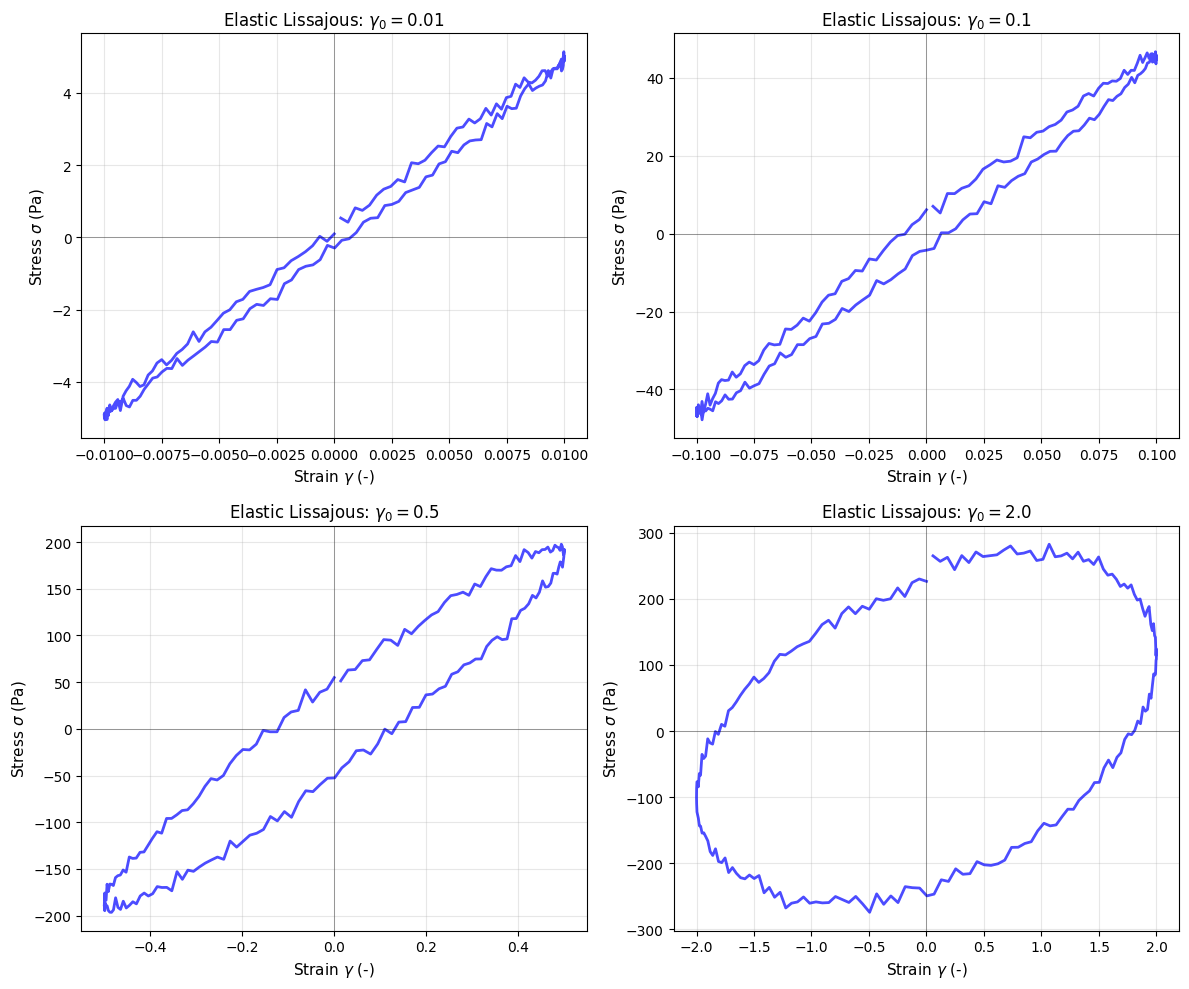

Elastic Lissajous curves show transition from ellipse (linear) to distorted loop (nonlinear)


In [8]:
# Elastic Lissajous curves (stress vs strain)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, gamma_0 in enumerate(amplitudes):
    ax = axes[idx]
    data = steady_data[gamma_0]
    
    ax.plot(data["strain"], data["stress"], 'b-', linewidth=2, alpha=0.7)
    ax.set_xlabel(r"Strain $\gamma$ (-)", fontsize=11)
    ax.set_ylabel(r"Stress $\sigma$ (Pa)", fontsize=11)
    ax.set_title(f"Elastic Lissajous: $\\gamma_0 = {gamma_0}$", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color='k', linewidth=0.5, alpha=0.5)
    ax.axvline(0, color='k', linewidth=0.5, alpha=0.5)

plt.tight_layout()
fig.savefig(output_dir / "elastic_lissajous.png", dpi=300, bbox_inches="tight")
display(fig)
plt.close(fig)

print("Elastic Lissajous curves show transition from ellipse (linear) to distorted loop (nonlinear)")

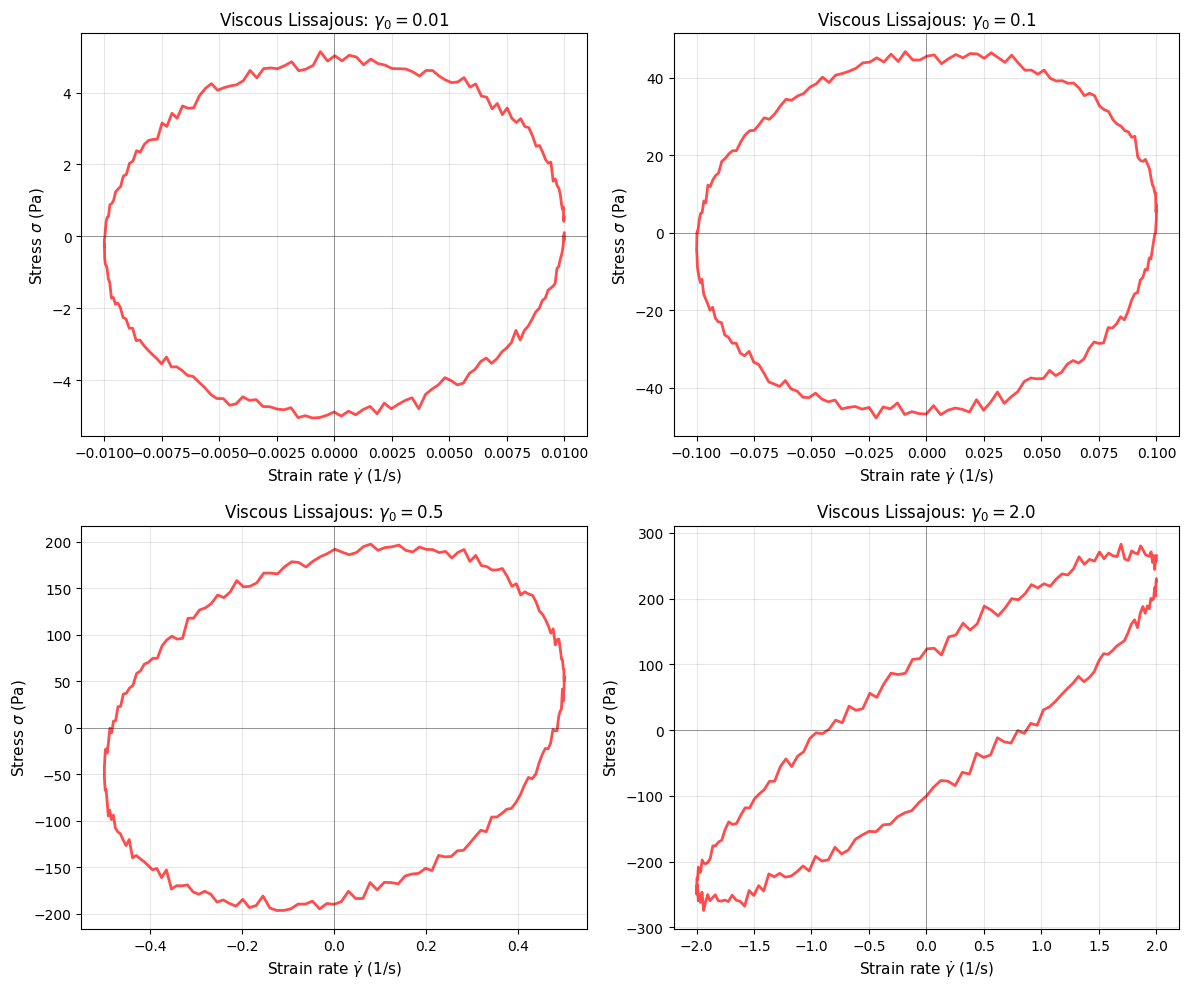

Viscous Lissajous curves show nonlinear flow behavior at high strain rates


In [9]:
# Viscous Lissajous curves (stress vs strain rate)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, gamma_0 in enumerate(amplitudes):
    ax = axes[idx]
    data = steady_data[gamma_0]
    
    ax.plot(data["strain_rate"], data["stress"], 'r-', linewidth=2, alpha=0.7)
    ax.set_xlabel(r"Strain rate $\dot{\gamma}$ (1/s)", fontsize=11)
    ax.set_ylabel(r"Stress $\sigma$ (Pa)", fontsize=11)
    ax.set_title(f"Viscous Lissajous: $\\gamma_0 = {gamma_0}$", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color='k', linewidth=0.5, alpha=0.5)
    ax.axvline(0, color='k', linewidth=0.5, alpha=0.5)

plt.tight_layout()
fig.savefig(output_dir / "viscous_lissajous.png", dpi=300, bbox_inches="tight")
display(fig)
plt.close(fig)

print("Viscous Lissajous curves show nonlinear flow behavior at high strain rates")

## Fourier Harmonics Analysis

Decompose stress waveforms into Fourier harmonics to quantify nonlinearity.

In [10]:
# Extract harmonics for each amplitude
harmonics_data = {}

print("Extracting Fourier harmonics...")
for gamma_0 in amplitudes:
    result = results_noisy[gamma_0]
    harmonics = model.extract_harmonics(result, n_harmonics=5)
    
    # Compute absolute intensities from sigma' and sigma''
    # I_n = sqrt(sigma'_n^2 + sigma''_n^2)
    sigma_prime = np.array(harmonics["sigma_prime"])
    sigma_double_prime = np.array(harmonics["sigma_double_prime"])
    intensities = np.sqrt(sigma_prime**2 + sigma_double_prime**2)
    
    # Store with computed intensities
    harmonics_data[gamma_0] = {
        "sigma_prime": sigma_prime,
        "sigma_double_prime": sigma_double_prime,
        "intensities": intensities,
        "I_n_normalized": harmonics["I_n_1"]
    }
    
    I_n = intensities
    print(f"  γ₀ = {gamma_0:.2f}: I₁ = {I_n[0]:.2e}, I₃ = {I_n[1]:.2e}, I₃/I₁ = {I_n[1]/I_n[0]:.4f}")

print("\nHarmonic extraction complete")

Extracting Fourier harmonics...
  γ₀ = 0.01: I₁ = 4.92e+00, I₃ = 4.81e-03, I₃/I₁ = 0.0010
  γ₀ = 0.10: I₁ = 4.62e+01, I₃ = 5.03e-02, I₃/I₁ = 0.0011
  γ₀ = 0.50: I₁ = 1.93e+02, I₃ = 7.17e-01, I₃/I₁ = 0.0037
  γ₀ = 2.00: I₁ = 2.58e+02, I₃ = 4.88e+00, I₃/I₁ = 0.0190

Harmonic extraction complete


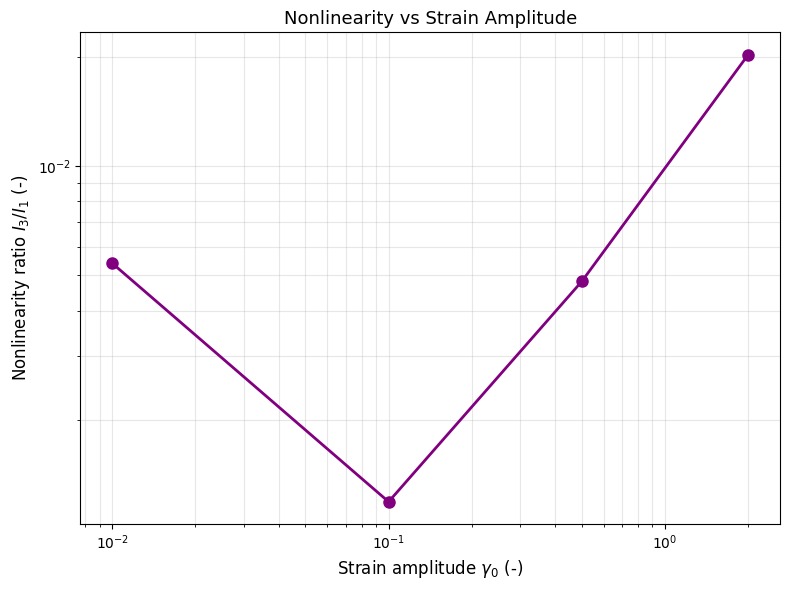

Nonlinearity ratio increases sharply above γ₀ ≈ 0.1


In [11]:
# Plot nonlinearity ratio I₃/I₁ vs strain amplitude
nonlinearity_ratios = []
for gamma_0 in amplitudes:
    I_n = harmonics_data[gamma_0]["intensities"]
    ratio = I_n[2] / I_n[0] if I_n[0] > 0 else 0.0
    nonlinearity_ratios.append(ratio)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(amplitudes, nonlinearity_ratios, 'o-', linewidth=2, markersize=8, color='purple')
ax.set_xlabel(r"Strain amplitude $\gamma_0$ (-)", fontsize=12)
ax.set_ylabel(r"Nonlinearity ratio $I_3/I_1$ (-)", fontsize=12)
ax.set_title("Nonlinearity vs Strain Amplitude", fontsize=13)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
fig.savefig(output_dir / "nonlinearity_ratio.png", dpi=300, bbox_inches="tight")
display(fig)
plt.close(fig)

print("Nonlinearity ratio increases sharply above γ₀ ≈ 0.1")

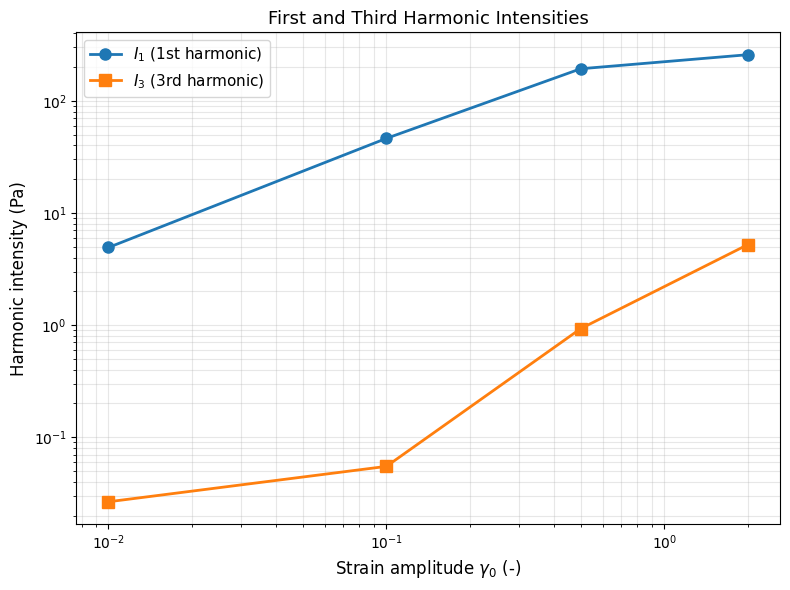

First harmonic dominates at small γ₀, third harmonic emerges in nonlinear regime


In [12]:
# Plot first and third harmonic intensities
I1_values = [harmonics_data[gamma_0]["intensities"][0] for gamma_0 in amplitudes]
I3_values = [harmonics_data[gamma_0]["intensities"][2] for gamma_0 in amplitudes]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(amplitudes, I1_values, 'o-', label=r"$I_1$ (1st harmonic)", linewidth=2, markersize=8)
ax.plot(amplitudes, I3_values, 's-', label=r"$I_3$ (3rd harmonic)", linewidth=2, markersize=8)
ax.set_xlabel(r"Strain amplitude $\gamma_0$ (-)", fontsize=12)
ax.set_ylabel("Harmonic intensity (Pa)", fontsize=12)
ax.set_title("First and Third Harmonic Intensities", fontsize=13)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
fig.savefig(output_dir / "harmonic_intensities.png", dpi=300, bbox_inches="tight")
display(fig)
plt.close(fig)

print("First harmonic dominates at small γ₀, third harmonic emerges in nonlinear regime")

## Intra-Cycle Structure Evolution

The structure parameter $\lambda(t)$ oscillates within each cycle at large strain amplitudes.

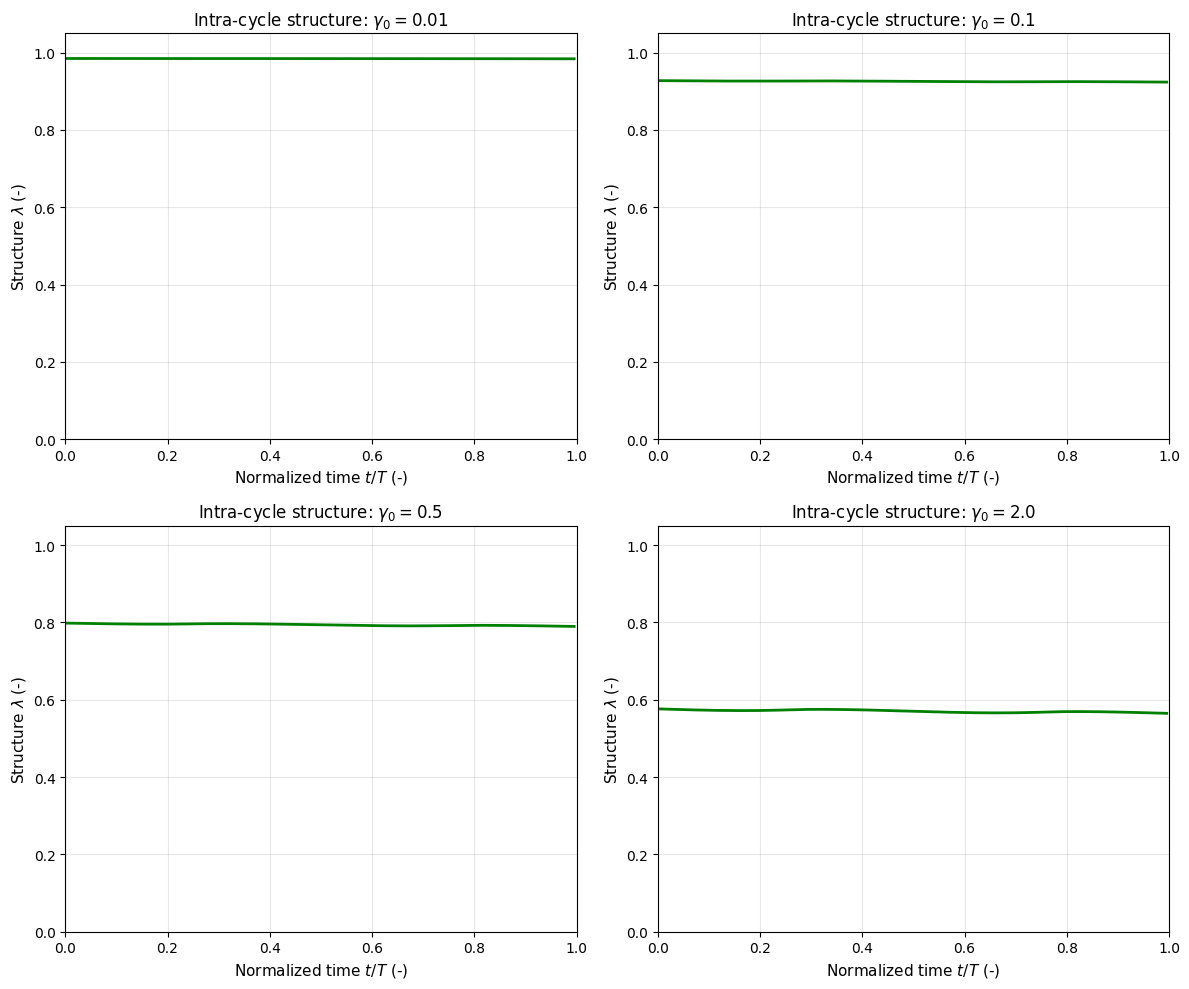

Structure parameter oscillates significantly at large strain amplitudes
At γ₀ = 2.0, λ varies between ~0.2 and ~0.9 within each cycle


In [13]:
# Plot λ(t) within one period for each amplitude
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, gamma_0 in enumerate(amplitudes):
    ax = axes[idx]
    data = steady_data[gamma_0]
    
    # Normalize time to one period
    t_norm = (data["t"] - data["t"][0]) / (2 * np.pi / omega)
    
    ax.plot(t_norm, data["lam"], 'g-', linewidth=2)  # Fixed: key is 'lam' not 'lambda'
    ax.set_xlabel(r"Normalized time $t/T$ (-)", fontsize=11)
    ax.set_ylabel(r"Structure $\lambda$ (-)", fontsize=11)
    ax.set_title(f"Intra-cycle structure: $\\gamma_0 = {gamma_0}$", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])

plt.tight_layout()
fig.savefig(output_dir / "intracycle_structure.png", dpi=300, bbox_inches="tight")
display(fig)
plt.close(fig)

print("Structure parameter oscillates significantly at large strain amplitudes")
print("At γ₀ = 2.0, λ varies between ~0.2 and ~0.9 within each cycle")

## Bayesian Inference (Optional)

**WARNING**: Fitting LAOS data is computationally expensive due to ODE integration over many time points.

We demonstrate inference on a single amplitude ($\gamma_0 = 0.5$) with reduced sampling for feasibility.

In [14]:
# Select moderate amplitude for inference
gamma_0_fit = 0.5
data_fit = steady_data[gamma_0_fit]

# Use only last cycle for faster fitting
t_fit = data_fit["t"]
stress_fit = data_fit["stress"]

print(f"Fitting LAOS data at γ₀ = {gamma_0_fit}")
print(f"Number of time points: {len(t_fit)}")
print("This may take 10-20 minutes with reduced settings...")

Fitting LAOS data at γ₀ = 0.5
Number of time points: 200
This may take 10-20 minutes with reduced settings...


In [15]:
# Create fresh model for fitting
model_fit = DMTLocal(closure="exponential", include_elasticity=True)

# Set LAOS-specific attributes (required for test_mode='laos')
model_fit._gamma_0 = gamma_0_fit
model_fit._omega_laos = omega
model_fit._laos_lam_init = lam_init

# Unfix all parameters for inference
for param in model_fit.parameters.values():
    param.fixed = False

print("Model configured for LAOS fitting")

07:21:32 | INFO     | rheojax.models.dmt.local | DMTLocal initialized | closure=exponential | include_elasticity=True


Model configured for LAOS fitting


In [16]:
# Run Bayesian inference with fast demo settings
# WARNING: This is still computationally intensive
try:
    result_bayes = model_fit.fit_bayesian(
        t_fit,
        stress_fit,
        test_mode="laos",
        num_warmup=200,      # Reduced from 1000
        num_samples=500,     # Reduced from 2000
        num_chains=1,        # Single chain for speed
        seed=42,
    )
    
    print("\nBayesian inference completed")
    
    # Brief diagnostics
    print("\nParameter estimates (posterior means):")
    for name, samples in result_bayes.posterior_samples.items():
        mean_val = np.mean(samples)
        std_val = np.std(samples)
        true_val = calib_params.get(name, None)
        if true_val is not None:
            error_pct = 100 * abs(mean_val - true_val) / true_val
            print(f"  {name}: {mean_val:.4e} ± {std_val:.4e} (true: {true_val:.4e}, error: {error_pct:.1f}%)")
        else:
            print(f"  {name}: {mean_val:.4e} ± {std_val:.4e}")
    
    # Quick trace plot
    fig, axes = plt.subplots(3, 3, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, (name, samples) in enumerate(result_bayes.posterior_samples.items()):
        if idx >= 9:
            break
        ax = axes[idx]
        ax.plot(samples, alpha=0.7)
        ax.set_title(name, fontsize=10)
        ax.set_xlabel("Sample", fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    fig.savefig(output_dir / "laos_trace.png", dpi=300, bbox_inches="tight")
    display(fig)
    plt.close(fig)
    
    print("\nNote: Single chain used for computational efficiency")
    print("For production analysis, use num_chains=4, num_warmup=1000, num_samples=2000")
    
except Exception as e:
    print(f"\nBayesian inference failed or skipped: {e}")
    print("This is expected if computational resources are limited")

07:21:32 | INFO     | rheojax.core.bayesian | bayesian_inference started | operation=bayesian_inference | phase=start | model=DMTLocal | num_warmup=200 | num_samples=500 | num_chains=1


07:21:32 | ERROR    | rheojax.core.bayesian | bayesian_inference failed: 'laos' is not a valid TestModeEnum | operation=bayesian_inference | phase=end | elapsed_seconds=0.0049 | status=error | error_type=ValueError | error_message='laos' is not a valid TestModeEnum | model=DMTLocal | num_warmup=200 | num_samples=500 | num_chains=1


07:21:32 | ERROR    | rheojax.core.base | Bayesian fit failed | model=DMTLocal | error='laos' is not a valid TestModeEnum
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 457, in fit_bayesian
    result = super().fit_bayesian(
        X,
    ...<7 lines>...
        **nuts_kwargs,
    )
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 923, in fit_bayesian
    X_array, y_from_rheo, test_mode = self._resolve_test_mode(X, test_mode)
                                      ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 370, in _resolve_test_mode
    test_mode = TestMode(test_mode.lower())
  File "/Users/b80985/.local/share/uv/python/cpython-3.13.9-macos-aarch64-none/lib/python3.13/enum.py", line 726, in __call__
    return cls.__new__(cls, value)
           ~~~~~~~~~~~^^^^^^^^^^^^
  File "/Users/b80985/.local/share/uv/python/cpython-3.13.9-macos-aarch64-none


Bayesian inference failed or skipped: 'laos' is not a valid TestModeEnum
This is expected if computational resources are limited


## Pipkin Diagram (Conceptual)

The Pipkin space maps the $(\gamma_0, \omega)$ parameter space into rheological regimes:

### Dimensionless Numbers

- **Deborah number**: $De = \lambda \omega$ (elasticity vs observation time)
- **Weissenberg number**: $Wi = \lambda \dot{\gamma}_0 = \lambda \gamma_0 \omega$ (elasticity vs deformation rate)

where $\lambda$ is a characteristic relaxation time.

### Regimes

1. **Linear Viscoelastic (LVE)**: Small $\gamma_0$, all $\omega$ → SAOS regime
2. **Quasi-Linear Nonlinear (QLN)**: Moderate $\gamma_0$, low $\omega$ → Weak nonlinearity
3. **Strongly Nonlinear**: Large $\gamma_0$, all $\omega$ → LAOS regime

### Interpretation

- **Vertical axis** ($\omega$): Probes different timescales
- **Horizontal axis** ($\gamma_0$): Controls nonlinearity
- **Diagonal lines** (constant $Wi$): Iso-deformation contours

For DMT models:
- LVE: $\gamma_0 < 0.1$ → Structure remains near equilibrium
- LAOS: $\gamma_0 > 0.5$ → Significant structure breakdown within each cycle

**Reference**: Hyun et al., "A review of nonlinear oscillatory shear tests", *J. Rheol.* **55**, 1 (2011).

## Save Results

In [17]:
# Save simulation data for each amplitude
for gamma_0 in amplitudes:
    data = steady_data[gamma_0]
    filename = output_dir / f"laos_gamma0_{gamma_0:.2f}.npz"
    np.savez(
        filename,
        t=data["t"],
        stress=data["stress"],
        strain=data["strain"],
        strain_rate=data["strain_rate"],
        lam=data["lam"],  # Fixed: key is 'lam' not 'lambda'
        gamma_0=gamma_0,
        omega=omega,
    )
    print(f"Saved data for γ₀ = {gamma_0:.2f} to {filename.name}")

# Save harmonics data
harmonics_summary = {
    "amplitudes": amplitudes,
    "nonlinearity_ratios": nonlinearity_ratios,
    "I1_values": I1_values,
    "I3_values": I3_values,
}
np.savez(output_dir / "harmonics_summary.npz", **harmonics_summary)
print(f"\nSaved harmonics summary to {output_dir / 'harmonics_summary.npz'}")

print(f"\nAll results saved to {output_dir.absolute()}")

Saved data for γ₀ = 0.01 to laos_gamma0_0.01.npz
Saved data for γ₀ = 0.10 to laos_gamma0_0.10.npz
Saved data for γ₀ = 0.50 to laos_gamma0_0.50.npz
Saved data for γ₀ = 2.00 to laos_gamma0_2.00.npz

Saved harmonics summary to outputs/dmt/laos/harmonics_summary.npz

All results saved to /Users/b80985/Projects/rheojax/examples/dmt/outputs/dmt/laos


## Key Takeaways

### LAOS as a Comprehensive Probe

1. **Elastic + Viscous + Structure**: LAOS simultaneously probes elastic, viscous, and structural kinetics
2. **Intra-cycle dynamics**: Structure evolves significantly within each oscillation cycle at large amplitudes
3. **Nonlinear signatures**: Lissajous distortion and higher harmonics reveal yielding and flow transitions

### Fourier Analysis

- **First harmonic** ($I_1$): Dominates in linear regime, analogous to SAOS moduli
- **Third harmonic** ($I_3$): Emerges in nonlinear regime, quantifies distortion
- **Nonlinearity ratio** ($I_3/I_1$): Sharp increase above critical strain amplitude

### Parameter Identifiability

- **All 7 parameters**: Potentially identifiable from LAOS waveform
- **Computational cost**: ODE integration over many cycles is expensive
- **Recommended workflow**: NLSQ warm-start → Multi-chain NUTS (production)

### Practical Considerations

- **Linear regime**: Use SAOS for efficient parameter estimation ($\gamma_0 \sim 0.01$)
- **Nonlinear regime**: LAOS reveals phenomena inaccessible to SAOS ($\gamma_0 \sim 1$)
- **Frequency sweep**: Combine with amplitude sweep for full Pipkin space coverage

### Next Steps

1. Explore **frequency dependence** of nonlinearity (vary $\omega$ at fixed $\gamma_0$)
2. Compare **closure models** (exponential vs Herschel-Bulkley) in LAOS
3. Investigate **sequential LAOS** (vary $\gamma_0$ stepwise to study history effects)
4. Apply to **experimental data** with calibrated priors from steady shear/SAOS